# covid-nsw
Driven by SQL, I explore [NSW COVID-19 cases by location](https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-aefcde60-3b0c-4bc0-9af1-6fe652944ec2/details?q=).

## Setup

Create SQL engine and load input CSV into a SQLite table:

In [1]:
from glob import glob
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)

covid_df = pd.read_csv(glob("./input/confirmed_cases*.csv")[0])
covid_df.to_sql("covid", engine, if_exists="replace", index=False)
covid_df.head(3)


,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),NaN,1
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),NaN,1
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),NaN,1


## Cleaning

### Missing
There are missing values in both `postcode` and `confirmed_by_pcr` columns:

In [2]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN notification_date IS NULL THEN 1 ELSE 0 END) AS 'nd_miss',
        SUM(CASE WHEN postcode IS 'None' THEN 1 ELSE 0 END) AS 'pc_miss',
        SUM(CASE WHEN lhd_2010_code IS  NULL THEN 1 ELSE 0 END) AS 'lhdc_miss',
        SUM(CASE WHEN lhd_2010_name IS NULL THEN 1 ELSE 0 END) AS 'lhdn_miss',
        SUM(CASE WHEN lga_code19 IS NULL THEN 1 ELSE 0 END) AS 'lgac_miss',
        SUM(CASE WHEN lga_name19 IS NULL THEN 1 ELSE 0 END) AS 'lgan_miss',
        SUM(CASE WHEN confirmed_by_pcr IS NULL THEN 1 ELSE 0 END) AS 'pcr_miss',
        SUM(CASE WHEN confirmed_cases_count IS NULL THEN 1 ELSE 0 END) AS 'confirmed_cases_miss'
    FROM covid
""",
    engine,
)


,nd_miss,pc_miss,lhdc_miss,lhdn_miss,lgac_miss,lgan_miss,pcr_miss,confirmed_cases_miss
0,0,530,0,0,0,0,41075,0


Although Local Government Area (LGA) information is not missing for rows with missing `postcode`, `postcode` is nevertheless difficult to impute as there can be multiple postcodes in an LGA (1:M).

Similarly, `confirmed_by_pcr` is difficult to impute. It records whether a case detected by Rapid Antigen Tests (RAT), reported to NSW Health, was also confirmed by PCR. All missing values were prior to 19 Jan 2022 and would be difficult to impute.

In [3]:
pd.read_sql_query(
    """
        SELECT MAX(notification_date) AS 'latest_pcr_miss_date'
        FROM covid
        WHERE confirmed_by_pcr IS NULL
    """,
    engine,
)


,latest_pcr_miss_date
0,2022-01-19


## Analysis
In this section, I use SQL queries and Python visualisations to highlight insights in the data.

### Daily Cases
Daily reported cases have overall trended upwards since reporting started on 25 Jan 2020. Daily cases peaked in Jan 2022, and then, less so, in Mar 2022. 

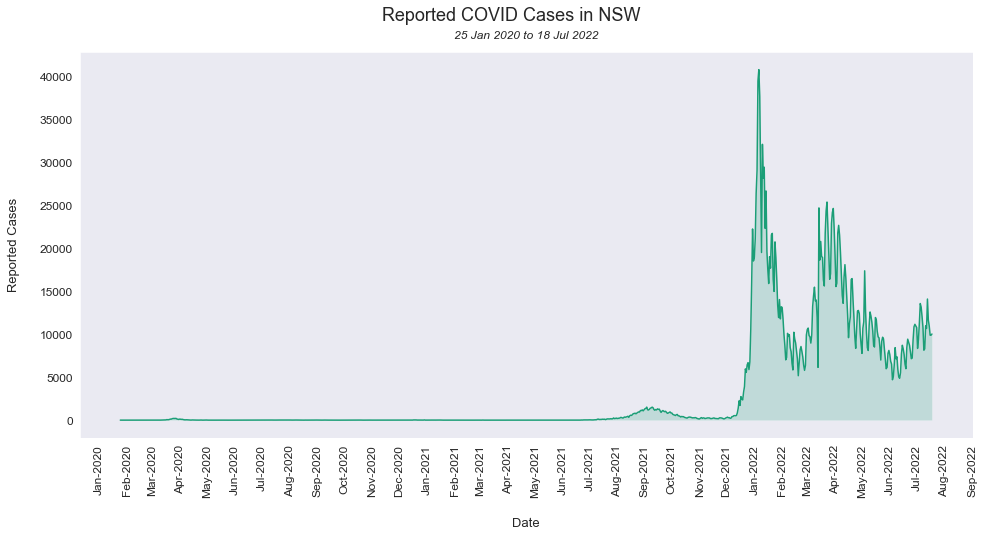

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# querying
daily_cases = pd.read_sql_query(
    """
        SELECT DATE(notification_date) AS 'date',
            SUM(confirmed_cases_count) AS 'reported_cases'
        FROM covid
        GROUP BY 1
    """,
    engine,
)

# transforming and extracting from DataFrame for visualisation
daily_cases["date"] = pd.to_datetime(daily_cases["date"], format="%Y-%m-%d")
start_date = daily_cases.date.min().strftime("%d %b %Y")
end_date = daily_cases.date.max().strftime("%d %b %Y")

# plotting visualisation
sns.set_style("dark")
sns.set_palette("Dark2")

fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="date", y="reported_cases", data=daily_cases, ax=ax)
plt.fill_between(x=daily_cases["date"], 
                 y1=daily_cases["reported_cases"], 
                 alpha=0.2)

# setting x-axis ticks
ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.tick_params(axis="both", labelsize=12)

# modifying line-chart parameters
ax.figure.suptitle("Reported COVID Cases in NSW", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.set_xlabel("Date", fontsize=13, labelpad=20)
ax.set_ylabel("Reported Cases", fontsize=13, labelpad=20)

fig.subplots_adjust(top=0.89)

plt.show()
plt.clf()


### COULD LABEL THIS WITH ANNOTATIONS OF THE ALL OF THE WAVES!

Drilling down, we see that the **10 highest daily reported cases all occurred in January 2022.** 11th to 16th highest are in the smaller, March 2022 spike in the line chart above.

In [5]:
pd.read_sql_query(
    """
    SELECT
        RANK() OVER (
            ORDER BY SUM(confirmed_cases_count) DESC
        ) AS 'rank',
        DATE(notification_date) AS 'date',
        STRFTIME('%m-%Y', notification_date) AS 'month_year',
        SUM(confirmed_cases_count) AS 'reported_cases'
    FROM covid
    GROUP BY 2
    ORDER BY 4 DESC
    LIMIT 20
""",
    engine,
)


,rank,date,month_year,reported_cases
0,1,2022-01-06,01-2022,40752
1,2,2022-01-05,01-2022,39431
2,3,2022-01-07,01-2022,37676
3,4,2022-01-10,01-2022,32070
4,5,2022-01-12,01-2022,29411
5,6,2022-01-04,01-2022,29031
6,7,2022-01-08,01-2022,28174
7,8,2022-01-11,01-2022,28137
8,9,2022-01-14,01-2022,26646
9,10,2022-01-03,01-2022,26374


#### "Zero" days
Since reporting began, there have been days with no COVID cases reported to NSW Health. 

We can see from the below query that:
* February 2020 was an entire _month_ of zero days
* Since 12 June 2021, there have been no zero days

In [6]:
zero_days_df = pd.read_sql_query(
    """
        WITH RECURSIVE dates(date) AS (
            VALUES((
                SELECT MIN(notification_date)
                FROM covid
                )
            )
            UNION ALL
            SELECT DATE(date, '+1 day')
            FROM dates
            WHERE date < (
                SELECT MAX(notification_date)
                FROM covid
                )
            )

        SELECT
            d.*
        FROM dates d
        LEFT JOIN covid c
            ON c.notification_date = d.date
        WHERE c.notification_date IS NULL
        ORDER BY 1
        """,
    engine,
)

zero_days_df.to_sql("zero_days", engine, if_exists="replace", index=False)
zero_days_df

,date
0,2020-01-26
1,2020-01-28
2,2020-01-29
3,2020-01-30
4,2020-01-31
...,...
86,2021-05-31
87,2021-06-01
88,2021-06-03
89,2021-06-11


In [7]:
pd.read_sql_query("""
    SELECT STRFTIME('%Y-%m', date) AS 'year_month',
        COUNT(*) AS 'zero_days_count'
    FROM zero_days
    GROUP BY 1
    ORDER BY 1
""", engine)

,year_month,zero_days_count
0,2020-01,5
1,2020-02,29
2,2020-05,9
3,2020-06,4
4,2020-09,3
5,2020-10,1
6,2020-11,3
7,2021-01,7
8,2021-02,10
9,2021-03,6


##### Streaks
As of the last date in the data, there have the following number of days since the last "zero day":

In [8]:
from IPython.display import Markdown
import numpy as np

last_zeroday = pd.to_datetime(zero_days_df.date.max())
days_since_zero = round((daily_cases.date.max() - last_zeroday) /\
                        np.timedelta64(1, 'D'))

display(Markdown(f"""
<div align='center'> Days since last zero day:</div>
<h1 align='center'>{days_since_zero}</h1>"""))


<div align='center'> Days since last zero day:</div>
<h1 align='center'>401</h1>

Since reporting started, the longest streak of "zero days" was 33 days, starting on 28 Jan 2020, and broken on 1 March 2020: 

In [9]:
# I minus 1 day from the difference between two dates where there were 1+ reported cases, as continuous days will return 1, but the streak is 0.

zd_streaks = \
    pd.read_sql_query("""
        WITH daily_cases AS (
            SELECT DATE(notification_date) AS 'date',
                SUM(confirmed_cases_count) AS 'reported_cases'
            FROM covid
            GROUP BY 1
        )

        SELECT *
        FROM (
            SELECT date AS 'date_streak_broken', 
                ROUND(
                    JULIANDAY(date) 
                    - JULIANDAY(
                            LAG(date) OVER (
                                ORDER BY date
                            )
                    )
                - 1) AS 'date_diff'
            FROM daily_cases
        )
        WHERE date_diff > 0

    """, engine)

# we filter out where `date_diff` = 0, as this means there were no zero days in between those dates

zd_streaks['date_diff'] = zd_streaks['date_diff'].astype(int)

zd_streaks

,date_streak_broken,date_diff
0,2020-01-27,1
1,2020-03-01,33
2,2020-05-12,2
3,2020-05-18,3
4,2020-05-23,1
5,2020-05-28,2
6,2020-05-30,1
7,2020-06-06,1
8,2020-06-11,1
9,2020-06-17,2


Examining the distribution, the 33-day zero-day streak above is an outlier, with the majority of zero days being isolated; breaking up continuous days of reported cases.

AttributeError: 'SubplotSpec' object has no attribute 'set_facecolor'

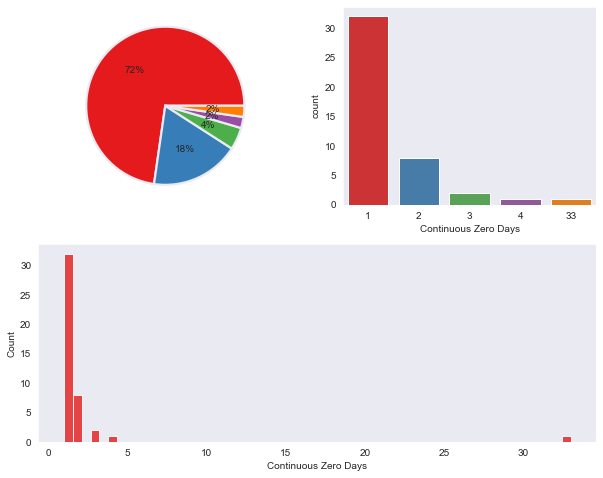

In [84]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# sns.set_style("dark", {"axes.facecolor": "#EAEAF2"})
sns.set_style("dark")
sns.set_palette("Set1", 5)

gs = gridspec.GridSpec(2,2)
f = plt.figure(figsize=(10,8))

zd_kde = f.add_subplot(gs[1,:])
sns.histplot(data=zd_streaks, x="date_diff", alpha=0.8,
              legend=False)\
    .set_xlabel("Continuous Zero Days")


zd_countp = f.add_subplot(gs[0,1])
sns.countplot(data=zd_streaks, x='date_diff')\
    .set_xlabel("Continuous Zero Days")


zd_prop = f.add_subplot(gs[0,0])
# transforming table for donut chart generation
zd_streaks_count =\
    zd_streaks\
        .groupby('date_diff').count()\
        .reset_index()\
        .rename(columns={'date_streak_broken': 
                         'date_diff_count'})
zd_donut =\
    plt.pie(zd_streaks_count['date_diff_count'],
        wedgeprops={'linewidth': 2.2, 
                    'edgecolor': '#EAEAF2'},
        autopct="%d%%")
gs[0,1].set_facecolor("#EAEAF2")

my_circle = plt.Circle((0,0), 0.7, color='#EAEAF2')
p = plt.gcf()
p.gca().add_artist(my_circle)


gs.tight_layout(f)
plt.show()
plt.clf()

In [43]:
sns.set_style("dark")
sns.axes_style("dark")

{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': False,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

In [12]:
### testing section

In [13]:
## following table shows when the last time a long streak of continuous
## covid case days was broken by a zero day - can use markdown display

pd.read_sql_query("""
    SELECT *
    FROM (
        SELECT date AS 'zero_day', 
            JULIANDAY(date) 
            - JULIANDAY(
                    LAG(date) OVER (
                        ORDER BY date
                    )
                ) AS 'date_difference'
        FROM zero_days z
    ) z_dif
    WHERE date_difference > 1
    ORDER BY date_difference DESC
    LIMIT 10
""", engine)

,zero_day,date_difference
0,2020-09-21,97.0
1,2020-05-10,71.0
2,2021-01-13,49.0
3,2020-11-10,39.0
4,2021-05-20,27.0
5,2021-03-07,16.0
6,2021-04-23,16.0
7,2020-11-25,13.0
8,2021-06-11,8.0
9,2020-06-05,7.0


In [14]:
### wanting to use this table of union dates, and status of cases present to calc "days since last zero_day"
zero_nzero_days_union =\
    pd.read_sql_query("""
        select date, 'n' AS 'cases_yn'
        from zero_days 
        union
        select notification_date, 'y' AS 'cases_yn' 
        from covid
    """, engine)

zero_nzero_days_union

,date,cases_yn
0,2020-01-25,y
1,2020-01-26,n
2,2020-01-27,y
3,2020-01-28,n
4,2020-01-29,n
...,...,...
901,2022-07-14,y
902,2022-07-15,y
903,2022-07-16,y
904,2022-07-17,y


In [15]:
### Calculating streaks

In [16]:
### Calculating difference in days from the current zero_day to the last
pd.read_sql_query("""
    select *
    from (
        select date, 
            julianday(date) - 
                julianday(
                    lag(date) OVER (
                        ORDER BY date
                    )
                ) as date_dif
        from zero_days z
    ) zz
""", engine)
### can use this table to highlight the longest gaps since last zero day
### can then try and find streaks by adding together "date_dif" but only if the previous day was also a '1'


# pd.read_sql_query("""
#     SELECT z.row_num, date,
#         SUM(
#             CASE WHEN EXISTS (
#                 SELECT 1
#                 FROM zero_days
#                 WHERE 
#                     row_num = z.row_num AND
#                     JULIANDAY(date) - JULIANDAY(z.date) = 1
#             ) THEN 1 ELSE 0 END
#         ) AS 'streak'
#     FROM zero_days z
#     GROUP BY z.row_num
# """, engine)

,date,date_dif
0,2020-01-26,NaN
1,2020-01-28,2.0
2,2020-01-29,1.0
3,2020-01-30,1.0
4,2020-01-31,1.0
...,...,...
86,2021-05-31,1.0
87,2021-06-01,1.0
88,2021-06-03,2.0
89,2021-06-11,8.0


In [17]:
### below is from previous version of the ipynb

### Geographic

#### "Greater Sydney"
The original dataset reports on *all* LGAs in NSW. In order to limit by "Greater Sydney", where needed, we will prepare a table that lists Greater Sydney LGAs.

Although there are some definition differences, we use the "Greater Sydney" LGAs as exhaustively defined in the COVID rules, published by the [NSW Government](https://www.nsw.gov.au/covid-19/stay-safe/protecting/advice-high-risk-groups/disability/local-councils-greater-sydney) and referenced in press conferences and media updates.

##### Importing, inspecting & cleaning
We will import & inspect a CSV that lists Greater Sydney LGAs, published by [NSW Government](https://www.nsw.gov.au/covid-19/stay-safe/protecting/advice-high-risk-groups/disability/local-councils-greater-sydney).

In [18]:
greater_sydney_lgas_df = pd.read_csv("input/greater_sydney_lgas.csv")

greater_sydney_lgas_df.to_sql("greater_sydney_lgas", engine, if_exists="replace")

greater_sydney_lgas_df


,lga_name
0,Bayside
1,Blacktown
2,Blue Mountains
3,Burwood
4,Camden
5,Campbelltown
6,Canada Bay
7,Canterbury-Bankstown
8,Central Coast
9,Cumberland


The LGA names in `greater_sydney_lgas` need to align with our main table, `covid_nsw_2`.

We will need to `LEFT JOIN` the two tables and identify LGAs in `greater_sydney_lgas` but not in `covid_nsw_2`. These will be the LGAs in Greater Sydney that will need to have their names amended to match those in `covid_nsw_2`.

In [19]:
pd.read_sql_query("""SELECT DISTINCT lga_name
                     FROM greater_sydney_lgas g
                     LEFT JOIN covid_nsw_2 c
                         ON g.lga_name = c.lga
                     WHERE lga IS NULL""", engine)

OperationalError: (sqlite3.OperationalError) no such table: covid_nsw_2
[SQL: SELECT DISTINCT lga_name
                     FROM greater_sydney_lgas g
                     LEFT JOIN covid_nsw_2 c
                         ON g.lga_name = c.lga
                     WHERE lga IS NULL]
(Background on this error at: http://sqlalche.me/e/14/e3q8)

Finding the way that `covid_nsw_2` refers to the identified Greater Sydney LGAs above:

In [ ]:
pd.read_sql_query("""SELECT DISTINCT lga 
                     FROM covid_nsw_2
                     WHERE lga LIKE 'Hunter%'
                         OR lga LIKE '%Hills%'
                     ORDER BY 1 DESC""", engine)

Updating the `greater_sydney_lgas` table to ensure it has the names in `covid_nsw_2`:

*NB: with `sqlalchemy`, both `UPDATE` and `CREATE TABLE` produce 'ResourceClosedError: This result object does not return rows. It has been closed automatically.' ([Source](https://github.com/sqlalchemy/sqlalchemy/issues/5433)). Thus, instead, we are using `UNION` so that later analysis can use `IN` for this table.*

In [ ]:
greater_sydney_lgas_df_2 = pd.read_sql_query("""SELECT lga_name
                                             FROM greater_sydney_lgas
                                             UNION
                                             SELECT DISTINCT lga 
                                             FROM covid_nsw_2
                                             WHERE lga LIKE 'Hunter%'
                                                 OR lga LIKE '%Hills%'
                                             ORDER BY 1""", engine)

greater_sydney_lgas_df_2.to_sql('greater_sydney_lgas', engine, if_exists='replace', index=False)

pd.read_sql_query("""SELECT *
                     FROM greater_sydney_lgas""", engine)

#### LGAs
##### NSW - Top 10

In [ ]:
pd.read_sql_query("""SELECT lga,
                         COUNT(*) cases
                     FROM covid_nsw_2
                     GROUP BY 1
                     ORDER BY 2 DESC
                     LIMIT 10""", engine)

#####  Greater Sydney - ranked

In [ ]:
pd.read_sql_query("""SELECT lga,
                         COUNT(*) cases
                     FROM covid_nsw_2
                     WHERE lga IN (
                         SELECT *
                         FROM greater_sydney_lgas
                     )
                     GROUP BY 1
                     ORDER BY 2 DESC""", engine)

##### Total reported cases, during "Delta" - top 10 in NSW - compared with pre-"Delta" total cases
Although unclear of the exact date, the "Delta" wave (also known as Australia's 3rd wave, and NSW's 2nd wave), this likely began on or around 18 June 2021.

Source 1: [ABC News 2021a, 'Outbreak, How Australia lost control of the COVID Delta variant | ABC News'](https://www.youtube.com/watch?v=M9MPXCpyCnY&ab_channel=ABCNewsIn-depth)

Source 2: [ABC News 2021b, 'NSW Health records additional COVID-19 case, masks mandatory for public transport in Greater Sydney'](https://www.abc.net.au/news/2021-06-18/nsw-records-one-covid-19-case-masks-for-public-transport/100225370)

In [ ]:
pd.read_sql_query("""WITH lga_top10_all AS (
                         SELECT lga,
                             COUNT(*) 'cases'
                         FROM covid_nsw_2
                         GROUP BY 1
                         ORDER BY 2 DESC
                         LIMIT 10
                     ),
                     
                     cases_pre_delta AS (
                         SELECT lga,
                             COUNT(*) 'cases_pre_delta'
                         FROM covid_nsw_2
                         WHERE notification_date < '2021-06-18'
                             AND lga IN
                                 (SELECT lga
                                  FROM lga_top10_all
                                 )
                         GROUP BY 1
                         ORDER BY 2 DESC
                     )
                     
                     SELECT l.lga,
                         c.cases_pre_delta,
                         (l.cases - c.cases_pre_delta) 'cases_post_delta',
                         l.cases 'cases_total'
                     FROM lga_top10_all l
                     LEFT JOIN cases_pre_delta c
                         ON l.lga = c.lga
                     ORDER BY 4 DESC""", engine)

##### No reported cases

In [ ]:
pd.read_sql_query("""SELECT DISTINCT lga
                     FROM postcode_to_lga
                     WHERE lga NOT IN (
                         SELECT lga
                         FROM covid_nsw_2
                         )
                     ORDER BY 1""", engine)